In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
from helpers import *

# load data.
height, weight, gender = load_data()

# build sampled x and y.
seed = 1
y = np.expand_dims(gender, axis=1)
X = np.c_[height.reshape(-1), weight.reshape(-1)]
y, X = sample_data(y, X, seed, size_samples=200)
x, mean_x, std_x = standardize(X)
tx = np.c_[np.ones((y.shape[0], 1)), x]

In [3]:
tx.shape, y.shape

((200, 3), (200, 1))

Sigmoid function

In [4]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    def sig_elem(z):
        if z <= 0:
            return np.exp(z) / (np.exp(z) + 1)
        else:
            return 1 / (1 + np.exp(-z))
    return np.vectorize(sig_elem)(x)

Logistic loss

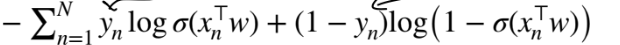
to multiply by 1/N

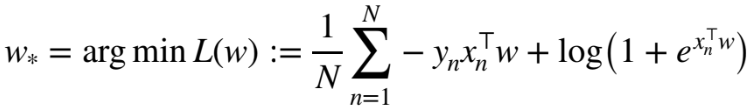

In [5]:
def compute_loss_logistic(y, tx, w):
    """Compute the cost by negative log likelihood.

    Args:
        y: outpus/labels
        tx: standardized inputs/features augmented with the first column filled with 1's
        w: weights used to calculate loss
    
    Returns:
        logistic loss
    """
    
    assert y.shape[0] == tx.shape[0]
    assert tx.shape[1] == w.shape[0]
    
    
    loss = np.sum(np.logaddexp(0, tx.dot(w))) - y.T.dot(tx.dot(w))
    return np.squeeze(loss).item() * (1 / y.shape[0])

    # Equivalent to:    
    # pred = sigmoid(tx.dot(w))
    # loss = y.T.dot(np.log(pred)) + (1 - y).T.dot(np.log(1 - pred))
    
    # return np.squeeze(-loss).item() * (1 / y.shape[0])


Logistic gradient

In [6]:
def compute_gradient_logistic(y, tx, w):
    """Compute the gradient of loss for logistic regression.

    Args:
        y: outpus/labels
        tx: standardized inputs/features augmented with the first column filled with 1's
        w: weights
        
    Returns:
        :return: logistic gradient
    """
    
    pred = sigmoid(tx.dot(w))
    return tx.T.dot(pred-y) * (1 / y.shape[0])

Batch iterator

In [7]:
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

In [8]:
def logistic_regression(y, tx, initial_w, max_iters, gamma):
    """Logistic regression with loss minimized using gradient descent

    Args:
        y: outpus/labels
        tx: standardized inputs/features augmented with the first column filled with 1's
        lambda_: penalty factor
        initial_w: initial weight vector
        max_iters: number of iterations
        gamma: step size

    Returns:
        w: minimized weight vector
        loss: corresponding loss
    """
    w = initial_w
    losses = []
    for _ in range(max_iters):
        gradient = compute_gradient_logistic(y, tx, w)
        loss = compute_loss_logistic(y, tx, w)
        losses.append(loss)
        w = w - gamma * gradient
    return w, losses

def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):
    """Regularized logistic regression using SGD.

    Args:
        y: outpus/labels
        tx: standardized inputs/features augmented with the first column filled with 1's
        lambda_: penalty factor
        initial_w: initial weight vector
        max_iters: number of iterations
        gamma: step size

    Returns:
        w: minimized weight vector
        loss: corresponding loss
    """
    w = initial_w
    losses = []
    for _ in range(max_iters):
        # gamma = 1/(n_iter+1) not sure? Gamma is passed as constant in the project description
        for y_b, tx_b in batch_iter(y, tx, batch_size=len(y), num_batches=1):
            gradient = compute_gradient_logistic(y_b, tx_b, w) + 2 * lambda_ * w
            loss = compute_loss_logistic(y_b, tx_b, w) + lambda_ * np.squeeze(w.T.dot(w))
            losses.append(loss)
            w = w - gamma * gradient
    return w, losses

Params

In [11]:
max_iters = 10000
threshold = 1e-8
gamma = 0.5
w = np.zeros((tx.shape[1], 1))

In [17]:
w, losses = logistic_regression(y, tx, w, max_iters, gamma)
losses

[0.38992997645921135,
 0.37444370132439175,
 0.3623066062396791,
 0.35254581751604314,
 0.34452799079690893,
 0.33782419988239354,
 0.33213414575431843,
 0.32724157572148926,
 0.3229869596553763,
 0.31925013469222135,
 0.31593893328989126,
 0.31298152578362304,
 0.310321138559593,
 0.3079123321926596,
 0.3057183283370269,
 0.3037090567160017,
 0.3018597060323182,
 0.3001496336330894,
 0.2985615346030494,
 0.29708080115273716,
 0.2956950234251538,
 0.294393596666464,
 0.2931674092852001,
 0.29200859305853555,
 0.2909103215414912,
 0.28986664619480307,
 0.28887236227112906,
 0.28792289836020873,
 0.28701422487948064,
 0.286142777838335,
 0.2853053949941405,
 0.2844992621221016,
 0.2837218675863602,
 0.2829709637609201,
 0.2822445341312657,
 0.2815407651295942,
 0.28085802193236276,
 0.2801948275888094,
 0.27954984496116025,
 0.2789218610474644,
 0.27830977333094864,
 0.27771257785914943,
 0.27712935880451683,
 0.2765592792979399,
 0.2760015733594096,
 0.27545553877708984,
 0.274920530808

In [18]:
w, losses = reg_logistic_regression(y, tx, lambda_=0.5, initial_w=w, max_iters=max_iters, gamma=gamma)
losses

[27.733757097818465,
 7.135515440112909,
 2.1179374733388414,
 0.9476798518814452,
 0.6803979332259422,
 0.6182221331798773,
 0.60347713001037,
 0.5999476950675043,
 0.5990997938289523,
 0.5988958238577808,
 0.5988467333946847,
 0.5988349164840813,
 0.5988320717701285,
 0.598831386938601,
 0.5988312220718697,
 0.5988311823815998,
 0.5988311728264857,
 0.5988311705261666,
 0.5988311699723826,
 0.5988311698390633,
 0.5988311698069677,
 0.598831169799241,
 0.5988311697973808,
 0.5988311697969328,
 0.5988311697968252,
 0.5988311697967991,
 0.598831169796793,
 0.5988311697967913,
 0.5988311697967911,
 0.598831169796791,
 0.598831169796791,
 0.5988311697967907,
 0.598831169796791,
 0.598831169796791,
 0.5988311697967909,
 0.598831169796791,
 0.5988311697967909,
 0.5988311697967911,
 0.5988311697967909,
 0.5988311697967909,
 0.5988311697967911,
 0.598831169796791,
 0.5988311697967911,
 0.5988311697967909,
 0.5988311697967912,
 0.598831169796791,
 0.598831169796791,
 0.598831169796791,
 0.5988